In [116]:
print("hola mundo")

hola mundo


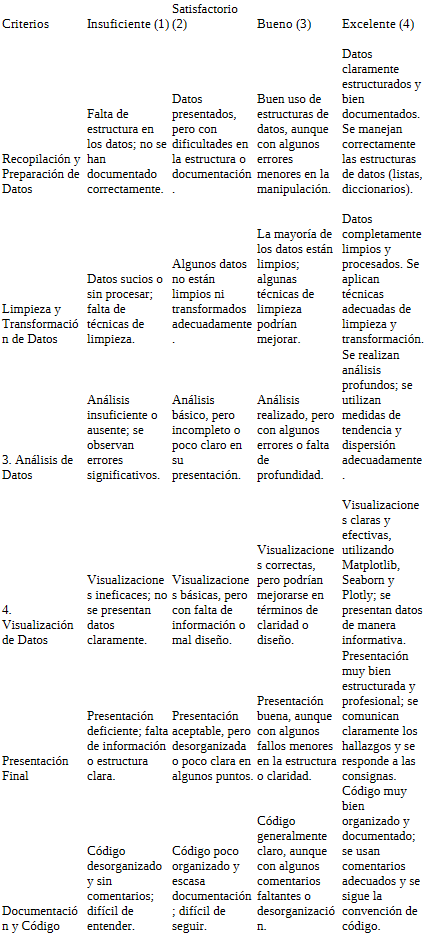

## 0. Cargar librerias y montar el drive

In [117]:
#!pip install gdown
import os
import argparse
import pandas as pd
import numpy as np
import unicodedata
import json
import zipfile
from collections import defaultdict
from datetime import datetime
from math import isnan

from google.colab import drive
import os

In [118]:
# --- Paso 1: Montar Google Drive ---
# Montar tu Google Drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'CLASE 08 _ Data Analytics.pdf'
 clientes.csv
 datasets_entrada
 datasets_salida
'Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics.ipynb'
 marketing.csv
'Pre entrega set de datos.docx'
 ventas.csv


## 1. Crear un documento en Google Colaboratory y cargar los sets de datos como DataFrames

In [119]:
# Ruta del archivo (ajústala a la carpeta real en tu Drive)
df_ventas = pd.read_csv("/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics/ventas.csv")
df_clientes = pd.read_csv("/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics/clientes.csv")
df_marketing = pd.read_csv("/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics/marketing.csv")

# Mostrar el DataFrame
print(f"""
df_ventas
{df_ventas}
{"*"*50}
df_clientes
{df_clientes}
{"*"*50}
df_marketing
{df_marketing}""")


df_ventas
      id_venta                producto   precio  cantidad fecha_venta  \
0          792       Cuadro decorativo   $69.94       5.0  02/01/2024   
1          811         Lámpara de mesa  $105.10       5.0  02/01/2024   
2         1156                Secadora   $97.96       3.0  02/01/2024   
3         1372                Heladera  $114.35       8.0  02/01/2024   
4         1546                Secadora  $106.21       4.0  02/01/2024   
...        ...                     ...      ...       ...         ...   
3030      1837         Horno eléctrico  $104.12       9.0  30/12/2024   
3031      2276                  Laptop   $85.27       9.0  30/12/2024   
3032      2696                  Laptop  $107.81       4.0  30/12/2024   
3033      2913              Smartphone   $99.85       7.0  30/12/2024   
3034      2930  Consola de videojuegos   $55.47       6.0  30/12/2024   

              categoria  
0            Decoración  
1            Decoración  
2     Electrodomésticos  
3     El

In [120]:
# ---------- Eliminación de acentos ----------
def sacar_acentos(texto):
    """
      Comprueba si el valor s es NaN (nulo o vacío).
      Esto se hace para no intentar modificar datos vacíos.
      Si está vacío, simplemente lo devuelve igual.
    """
    if pd.isna(texto):
        return texto

    """
      nk = unicodedata.normalize('NFKD', s)
      Usa el módulo unicodedata para normalizar los caracteres Unicode.
      'NFKD' separa los caracteres con acento en carácter base + marca de acento.
      "á"  →  "a" + " ́ "   (letra + tilde)
      "ñ"  →  "n" + "~"      virgulilla
    """
    texto = str(texto)
    texto_normalizado = unicodedata.normalize('NFKD', texto)
    """
      Recorre cada carácter de la cadena nk y elimina los que son marcas de acento.
      unicodedata.combining(c) devuelve True si el carácter es una tilde, diéresis o similar.
      Luego junta de nuevo todos los caracteres que quedan (sin acentos).
    """
    salida = ''.join([c for c in texto_normalizado if not unicodedata.combining(c)])
    return salida

In [121]:
def safe_str(x):
    if pd.isna(x):
        return ""
    return str(x)

In [122]:
# ---------- Detección de valores perdidos ----------
def buscar_valores_perdidos(valor):
    """
    Determina si un valor debe considerarse como "perdido" o "faltante".

    Pasos:
    1. Si el valor ya es NaN reconocido por pandas → devuelve True.
    2. Convierte el valor a texto, elimina espacios al inicio y final, y lo pasa a minúsculas.
    3. Elimina acentos para evitar errores de escritura.
    4. Compara el valor con una lista predefinida de expresiones comunes que indican ausencia de datos.
    """
    if pd.isna(valor):
        return True

    valor_texto = str(valor).strip().lower()
    valor_texto = sacar_acentos(valor_texto)

    valores_faltantes = {
        '', 'na', 'n/a', 'null', 'none', 'sin dato', 's/d', 'nd', '-', '--', '?', 'sin_dato'
    }

    return valor_texto in valores_faltantes

In [123]:
# ---------- Detección de valores perdidos ----------
def buscar_valores_perdidos(valor):
    """
    Determina si un valor debe considerarse como "perdido" o "faltante".
      Convierte el valor a texto, elimina espacios al inicio y final, y pasa todo a minúsculas.
      Así evita errores por escritura distinta (" NA ", "Na", "na", etc.).
    Pasos:
    1. Si el valor ya es NaN reconocido por pandas → devuelve True.
    2. Convierte el valor a texto, elimina espacios al inicio y final, y lo pasa a minúsculas.
    3. Elimina acentos para evitar errores de escritura.
    4. Compara el valor con una lista predefinida de expresiones comunes que indican ausencia de datos.

    Ejemplo:
        buscar_valores_perdidos(" N/A ")     → True
        buscar_valores_perdidos("SIN DATO")  → True
        buscar_valores_perdidos("Ariel")     → False


    """
    if pd.isna(valor):
        return True

    valor_texto = str(valor).strip().lower()
    """
    llamo a sacar acentos
    """
    valor_texto = sacar_acentos(valor_texto)

    valores_faltantes = {
        '', 'na', 'n/a', 'null', 'none', 'sin dato', 's/d', 'nd', '-', '--', '?', 'sin_dato'
    }
    """
    Si tiene valores perdidos devuelve True
    Si el valor ya es un NaN reconocido por pandas, devuelve True.
    Es decir, ya está marcado como “faltante”.
    """
    return valor_texto in valores_faltantes

In [124]:
# ---------- Detección de valores atípicos ----------
def mascara_valores_atipicos_rango_intercuartil(serie_datos):
    """
    Identifica los valores atípicos (outliers) en una serie numérica,
    por ejemplo una columna de un DataFrame de pandas.

    Utiliza el método del Rango Intercuartílico (IQR - Interquartile Range),
    una técnica estadística clásica que detecta valores que se encuentran
    demasiado lejos del rango típico de los datos.

    Proceso:
    1. Se eliminan los valores nulos.
    2. Se calculan los cuartiles Q1 (25%) y Q3 (75%).
    3. Se obtiene el rango intercuartílico (IQR = Q3 - Q1).
    4. Se establecen límites inferior y superior:
       - Límite inferior = Q1 - 1.5 * IQR
       - Límite superior = Q3 + 1.5 * IQR
    5. Los valores menores al límite inferior o mayores al límite superior
       se consideran valores atípicos (True).

    Si la cantidad de datos válidos es menor que 4,
    se considera que no hay suficientes valores para calcular los cuartiles
    y se devuelve una serie de valores False.

    Retorna:
        Serie booleana del mismo tamaño que la serie original.
        - True: el valor es atípico.
        - False: el valor está dentro del rango normal.
    """
    serie_limpia = serie_datos.dropna().astype(float)

    if serie_limpia.shape[0] < 4:
        return pd.Series([False] * len(serie_datos), index=serie_datos.index)

    cuartil_1 = serie_limpia.quantile(0.25)
    cuartil_3 = serie_limpia.quantile(0.75)
    rango_intercuartil = cuartil_3 - cuartil_1

    limite_inferior = cuartil_1 - 1.5 * rango_intercuartil
    limite_superior = cuartil_3 + 1.5 * rango_intercuartil

    return (serie_datos < limite_inferior) | (serie_datos > limite_superior)
    #                                      ^
    #                                      |___recordar que es un o logico ende es una booleana con dos condiciones

In [125]:
# ---------- Detección de valores atípicos mediante Z-Score ----------
def mascara_valores_atipicos_zscore(serie_datos, umbral=3.0):
    #                                                  ^___parámetro por default
    """
    Identifica valores atípicos (outliers) en una serie numérica
    usando el método del puntaje Z (Z-Score).

    Este método mide cuántas desviaciones estándar se aleja
    cada valor de la media de la serie.
        El método Z-Score es útil cuando los datos siguen una distribución normal (gaussiana).
        Si tus datos son asimétricos o tienen muchos ceros, te conviene usar el rango intercuartílico (IQR), ya que es más robusto frente a valores extremos.
        En una buena práctica de limpieza, conviene usar ambos métodos y comparar.
    Parámetros:
        serie_datos : pd.Series
            Serie numérica a analizar.
        umbral : float (por defecto 3.0)
            Límite para considerar un valor como atípico.
            Cuanto más bajo, más estricta la detección.

    Retorna:
        pd.Series (booleana)
            - True: valor considerado atípico.
            - False: valor normal.
    """
    serie_limpia = serie_datos.dropna().astype(float)

    # Si hay muy pocos datos o todos son iguales → no hay outliers
    if serie_limpia.shape[0] < 4 or serie_limpia.std() == 0:
        return pd.Series([False] * len(serie_datos), index=serie_datos.index)

    # Cálculo del puntaje Z
    puntaje_z = (serie_datos - serie_limpia.mean()) / serie_limpia.std()

    # Devuelve True si el valor está más alejado que el umbral
    return puntaje_z.abs() > umbral

In [126]:
# ---------- Detección de problemas en un DataFrame ----------
def detectar_problemas_dataframe(dataframe):
    """
    Analiza un DataFrame y detecta posibles "problemas" o "issues" en los datos.

    Devuelve:
      resumen_general: dict → Información general del DataFrame (filas, columnas, nulos, duplicados, etc.)
      chequeos_por_columna: dict → Validaciones y estadísticas individuales por cada columna
      problemas_dataframe: DataFrame → Cada fila con problemas detectados, indicando cuáles son y una muestra

    Objetivo:
      Esta función busca enseñar cómo realizar una exploración de calidad de datos
      paso a paso, combinando estadísticas básicas con detección de inconsistencias.
    """

    # --- 1. Información general del DataFrame ---
    resumen_general = {
        'cantidad_filas': dataframe.shape[0],
        'cantidad_columnas': dataframe.shape[1],
        'nombres_columnas': list(dataframe.columns.astype(str)),
        'tipos_datos': dataframe.dtypes.apply(lambda x: str(x)).to_dict(),
        'nulos_por_columna': dataframe.isna().sum().to_dict()
    }

    # Identificar filas duplicadas (completamente iguales)
    mascara_duplicados = dataframe.duplicated(keep=False)
    resumen_general['filas_duplicadas'] = int(mascara_duplicados.sum())

    # Detección de columnas que podrían ser identificadores únicos (id, dni, etc.)
    posibles_identificadores = [
        c for c in dataframe.columns.astype(str)
        if any(palabra in c.lower() for palabra in ['id', 'dni', 'cuil', 'cuit', 'legajo', 'codigo', 'clave'])
    ]
    resumen_general['posibles_identificadores'] = posibles_identificadores

    # --- 2. Análisis por columna ---
    chequeos_por_columna = {}

    for nombre_columna in dataframe.columns:
        serie = dataframe[nombre_columna]
        info_columna = {'tipo_dato': str(serie.dtype),
                        'cantidad_nulos': int(serie.isna().sum())}

        # --- Columnas de texto ---
        if serie.dtype == object or pd.api.types.is_string_dtype(serie):
            serie_texto = serie.astype(str)

            # Verificar espacios al inicio o final
            info_columna['espacios_inicio'] = int(serie_texto.str.match(r'^\s+').sum())
            info_columna['espacios_final'] = int(serie_texto.str.match(r'\s+$').sum())

            # Comparar variantes por mayúsculas/minúsculas
            try:
                unicos_original = set(serie_texto.dropna().unique())
                unicos_minuscula = set(serie_texto.dropna().str.lower().unique())
                info_columna['valores_unicos'] = len(unicos_original)
                info_columna['valores_unicos_minuscula'] = len(unicos_minuscula)
                info_columna['existen_variantes_mayusculas'] = len(unicos_minuscula) < len(unicos_original)
            except Exception:
                info_columna['valores_unicos'] = int(serie.nunique(dropna=True))
                info_columna['valores_unicos_minuscula'] = None
                info_columna['existen_variantes_mayusculas'] = None

            # Verificar variantes con o sin acentos
            try:
                serie_sin_acentos = serie_texto.dropna().map(lambda x: sacar_acentos(x).lower())
                conteo_grupos = serie_sin_acentos.groupby(serie_sin_acentos).size()
                conflictos = conteo_grupos[conteo_grupos > 1]

                info_columna['grupos_variantes_acentos'] = int(conflictos.shape[0])
                ejemplos_conflictos = {}

                if not conflictos.empty:
                    for valor in conflictos.index[:5]:
                        originales = sorted(list(serie_texto[serie_sin_acentos == valor].unique())[:10])
                        ejemplos_conflictos[valor] = originales

                info_columna['ejemplos_variantes_acentos'] = ejemplos_conflictos

            except Exception:
                info_columna['grupos_variantes_acentos'] = None
                info_columna['ejemplos_variantes_acentos'] = {}

            # Detectar textos que representan valores faltantes
            info_columna['tokens_faltantes'] = int(
                serie_texto.map(lambda v: buscar_valores_perdidos(v)).sum()
            )

            # Muestra de algunos valores
            info_columna['muestra_valores'] = list(serie_texto.dropna().unique()[:10])

        # --- Columnas numéricas ---
        elif pd.api.types.is_numeric_dtype(serie):
            serie_numerica = serie.dropna().astype(float)
            if not serie_numerica.empty:
                info_columna['media'] = float(serie_numerica.mean())
                info_columna['desviacion_estandar'] = float(serie_numerica.std())
                info_columna['minimo'] = float(serie_numerica.min())
                info_columna['maximo'] = float(serie_numerica.max())
            else:
                info_columna.update({'media': None, 'desviacion_estandar': None,
                                     'minimo': None, 'maximo': None})

            # Detección de valores atípicos
            if len(serie_numerica) >= 4:
                q1 = serie_numerica.quantile(0.25)
                q3 = serie_numerica.quantile(0.75)
                rango_iqr = q3 - q1
                limite_inferior = q1 - 1.5 * rango_iqr
                limite_superior = q3 + 1.5 * rango_iqr

                mascara_atipicos = (serie_numerica < limite_inferior) | (serie_numerica > limite_superior)
                info_columna['valores_atipicos_iqr'] = int(mascara_atipicos.sum())
                info_columna['limites_iqr'] = (float(limite_inferior), float(limite_superior))
            else:
                info_columna['valores_atipicos_iqr'] = None
                info_columna['limites_iqr'] = None

            # Detección de outliers por Z-Score
            if len(serie_numerica) >= 4 and serie_numerica.std() != 0:
                z = (serie_numerica - serie_numerica.mean()) / serie_numerica.std()
                info_columna['valores_atipicos_z'] = int((z.abs() > 3).sum())
            else:
                info_columna['valores_atipicos_z'] = None

        # --- Columnas de fecha ---
        else:
            fechas_convertidas = pd.to_datetime(serie, errors='coerce', dayfirst=True)
            info_columna['valores_fecha_convertidos'] = int(fechas_convertidas.notna().sum())
            info_columna['muestra_valores'] = list(serie.dropna().unique()[:10])

        chequeos_por_columna[str(nombre_columna)] = info_columna

    # --- 3. Revisión fila por fila ---
    filas_con_problemas = []
    for indice, fila in dataframe.iterrows():
        lista_problemas = []

        # Duplicados exactos
        if mascara_duplicados.loc[indice]:
            lista_problemas.append("fila_duplicada")

        for nombre_columna in dataframe.columns:
            valor = fila[nombre_columna]
            info_columna = chequeos_por_columna[str(nombre_columna)]

            # Si es texto
            if isinstance(valor, str):
                if valor != valor.strip():
                    lista_problemas.append(f"espacios_en_columna_{nombre_columna}")

                if info_columna.get('existen_variantes_mayusculas'):
                    lista_problemas.append(f"inconsistencia_mayusculas_{nombre_columna}")

                if info_columna.get('grupos_variantes_acentos', 0) > 0:
                    lista_problemas.append(f"variantes_acentos_{nombre_columna}")

                if buscar_valores_perdidos(valor):
                    lista_problemas.append(f"token_faltante_{nombre_columna}")

            # Si es numérico
            elif pd.api.types.is_numeric_dtype(type(valor)):
                limites_iqr = info_columna.get('limites_iqr')
                if limites_iqr and (valor < limites_iqr[0] or valor > limites_iqr[1]):
                    lista_problemas.append(f"valor_atipico_iqr_{nombre_columna}")

                media = info_columna.get('media')
                desvio = info_columna.get('desviacion_estandar')
                if desvio not in (None, 0):
                    if abs((valor - media) / desvio) > 3:
                        lista_problemas.append(f"valor_atipico_z_{nombre_columna}")

        if lista_problemas:
            filas_con_problemas.append({
                'indice_fila': indice,
                'problemas_detectados': ';'.join(sorted(set(lista_problemas))),
                'muestra_fila': json.dumps({str(c): str(fila[c]) for c in dataframe.columns[:8]})
            })

    problemas_dataframe = pd.DataFrame(filas_con_problemas)
    return resumen_general, chequeos_por_columna, problemas_dataframe

In [127]:
# ---------- Limpieza aplicada por columna ----------
def aplicar_regla_columna(serie, regla):
    """
    Aplica una regla de limpieza o transformación sobre una serie (columna) de un DataFrame.

    Parámetros:
        serie: pd.Series → Columna del DataFrame sobre la cual se aplicará la regla.
        regla: tuple o string → ('tipo', opciones_dict)
            Ejemplo: ('numeric', {'remove_thousands': True, 'as_int': True})

    Tipos de regla disponibles:
        - 'strip'            → Elimina espacios en blanco al inicio y final.
        - 'lower'            → Convierte texto a minúsculas.
        - 'upper'            → Convierte texto a mayúsculas.
        - 'title'            → Convierte texto a formato título ("Juan Perez").
        - 'remove_accents'   → Elimina acentos y caracteres especiales.
        - 'numeric'          → Convierte texto a número, con opciones.
        - 'date'             → Convierte texto a fecha, con formatos y orden configurables.

    Retorna:
        Una nueva serie (pd.Series) con la transformación aplicada.

    Objetivo pedagógico:
        Enseñar cómo parametrizar limpiezas de datos sin escribir múltiples funciones,
        permitiendo automatizar tareas repetitivas sobre distintas columnas.
    """

    tipo_regla, opciones = regla if isinstance(regla, tuple) else (regla, {})
    serie_resultado = serie.copy()

    # --- Reglas básicas de texto ---
    if tipo_regla == 'strip':
        serie_resultado = serie_resultado.map(
            lambda valor: safe_str(valor).strip() if not pd.isna(valor) else valor
        )

    elif tipo_regla == 'lower':
        serie_resultado = serie_resultado.map(
            lambda valor: safe_str(valor).strip().lower() if not pd.isna(valor) else valor
        )

    elif tipo_regla == 'upper':
        serie_resultado = serie_resultado.map(
            lambda valor: safe_str(valor).strip().upper() if not pd.isna(valor) else valor
        )

    elif tipo_regla == 'title':
        serie_resultado = serie_resultado.map(
            lambda valor: safe_str(valor).strip().title() if not pd.isna(valor) else valor
        )

    elif tipo_regla == 'remove_accents':
        serie_resultado = serie_resultado.map(
            lambda valor: sacar_acentos(safe_str(valor)).strip() if not pd.isna(valor) else valor
        )

    # --- Regla: conversión a número ---
    elif tipo_regla == 'numeric':
        # Opciones posibles:
        #   remove_non_digits → elimina todo lo que no sea número o signo
        #   remove_thousands  → elimina separadores de miles (,)
        #   as_int            → fuerza conversión a entero

        def convertir_a_numero(valor):
            if pd.isna(valor):
                return np.nan

            texto = str(valor).strip()

            if opciones.get('remove_non_digits', False):
                texto = ''.join([c for c in texto if c.isdigit() or c in '.-'])

            if opciones.get('remove_thousands', False):
                texto = texto.replace(',', '')

            try:
                if opciones.get('as_int', False):
                    return int(float(texto))
                else:
                    return float(texto)
            except Exception:
                return np.nan

        serie_resultado = serie_resultado.map(convertir_a_numero)

    # --- Regla: conversión a fecha ---
    elif tipo_regla == 'date':
        # Opciones posibles:
        #   formats → lista de formatos esperados (por ejemplo ['%d/%m/%Y'])
        #   dayfirst → si las fechas vienen con el día antes del mes (True por defecto)

        def convertir_a_fecha(valor):
            if pd.isna(valor):
                return pd.NaT

            texto = str(valor).strip()

            # Intentar con formatos personalizados si fueron definidos
            if 'formats' in opciones and opciones['formats']:
                for formato in opciones['formats']:
                    try:
                        return pd.to_datetime(datetime.strptime(texto, formato))
                    except Exception:
                        continue

            # Intentar conversión automática
            try:
                return pd.to_datetime(
                    texto,
                    dayfirst=opciones.get('dayfirst', True),
                    errors='coerce'
                )
            except Exception:
                return pd.NaT

        serie_resultado = serie_resultado.map(convertir_a_fecha)

    # Si no se reconoce el tipo, se devuelve la serie sin cambios
    return serie_resultado

In [128]:
def limpiar_dataframe(df, reglas_columnas=None):
    """
    Aplica un proceso general de limpieza sobre un DataFrame de pandas.

    Parámetros:
        df : pd.DataFrame
            DataFrame original a limpiar.

        reglas_columnas : dict (opcional)
            Diccionario con las reglas específicas para ciertas columnas.
            Cada clave es el nombre de la columna y el valor es una tupla con la regla.
            Ejemplo:
                {
                    'nombre': 'title',
                    'monto': ('numeric', {'remove_thousands': True}),
                    'fecha_nacimiento': ('date', {'formats': ['%d/%m/%Y']})
                }

    Proceso de limpieza aplicado:
        1 Normalización de nombres de columnas → elimina espacios.
        2 Aplicación de reglas personalizadas por columna.
        3 Limpieza básica por defecto para columnas de texto (elimina espacios y tokens nulos).
        4 Eliminación de filas duplicadas exactas, manteniendo la primera ocurrencia.

    Retorna:
        pd.DataFrame → Una copia limpia del DataFrame original.

    Objetivo pedagógico:
        Enseñar a los alumnos cómo estructurar un flujo de limpieza de datos reutilizable y modular,
        separando la lógica de transformación por columnas, y garantizando claridad en los pasos.
    """

    # Creamos una copia del DataFrame original para no modificar los datos fuente.
    df_limpio = df.copy()

    # Si no se pasan reglas, se inicializa un diccionario vacío.
    reglas_columnas = reglas_columnas or {}

    # --- Paso 1: Normalización de nombres de columnas ---
    # Eliminamos espacios en blanco al inicio o final del nombre de cada columna.
    df_limpio.columns = [str(nombre_columna).strip() for nombre_columna in df_limpio.columns]

    # --- Paso 2: Aplicar reglas específicas por columna ---
    for nombre_columna in df_limpio.columns:
        if nombre_columna in reglas_columnas:
            # Si la columna tiene una regla definida, se aplica.
            df_limpio[nombre_columna] = aplicar_regla_columna(
                df_limpio[nombre_columna],
                reglas_columnas[nombre_columna]
            )
        else:
            # --- Limpieza por defecto ---
            # Para columnas de texto sin regla específica, se aplica limpieza básica:
            #   - Elimina espacios en blanco
            #   - Convierte tokens de "datos faltantes" en NaN
            if (
                df_limpio[nombre_columna].dtype == object
                or pd.api.types.is_string_dtype(df_limpio[nombre_columna])
            ):
                df_limpio[nombre_columna] = df_limpio[nombre_columna].map(
                    lambda valor: np.nan if buscar_valores_perdidos(valor)
                    else (safe_str(valor).strip() if not pd.isna(valor) else valor)
                )

    # --- Paso 3: Eliminar filas duplicadas ---
    # Se eliminan filas idénticas completas, manteniendo solo la primera aparición.
    # Esto evita redundancia y asegura consistencia de datos.
    df_limpio = df_limpio.drop_duplicates(keep='first').reset_index(drop=True)

    # Retorna el DataFrame ya limpio y listo para análisis o almacenamiento.
    return df_limpio

In [129]:
# ---------- Ejecución desde CLI ----------
def parse_args():
    p = argparse.ArgumentParser(description="Revisar y corregir CSVs en un folder.")
    p.add_argument('--in', dest='input_dir', required=True, help="Carpeta con CSVs a procesar.")
    p.add_argument('--out', dest='output_dir', default='./data_out', help="Carpeta de salida.")
    return p.parse_args()

In [130]:
# ---------- Flujo principal ----------

def procesar_carpeta(directorio_entrada, directorio_salida, reglas_columnas=None):
    """
    Ejecuta el flujo completo de procesamiento de archivos CSV contenidos en un directorio.

    Parámetros:
        directorio_entrada : str
            Ruta donde se encuentran los archivos CSV originales.
        directorio_salida : str
            Ruta donde se guardarán los resultados (archivos limpios y reportes).
        reglas_columnas : dict (opcional)
            Diccionario con las reglas específicas de limpieza por columna.
            Ver función `aplicar_regla_columna()` para los tipos posibles.

    Flujo general del proceso:
        1 Crear carpetas de salida (reports y cleaned)
        2 Detectar problemas en los CSV antes de limpiar
        3 Aplicar limpieza con `limpiar_dataframe()`
        4 Detectar nuevamente para comparar resultados
        5 Guardar:
           5.1 - Reportes antes y después
           5.2 - DataFrames limpios
           5.3 - Un resumen global del proceso
        6 Comprimir todo en un ZIP

    Retorna:
        None
        (Pero deja archivos y reportes en el directorio indicado)

    Objetivo pedagógico:
        Mostrar un flujo de trabajo completo para la limpieza automatizada de datos,
        reforzando el uso de funciones auxiliares, estructuras de control y manejo de archivos.
    """

    # --- Paso 1: Crear estructura de carpetas de salida ---
    os.makedirs(directorio_salida, exist_ok=True)
    directorio_reportes = os.path.join(directorio_salida, "reportes")
    directorio_limpios = os.path.join(directorio_salida, "limpios")
    os.makedirs(directorio_reportes, exist_ok=True)
    os.makedirs(directorio_limpios, exist_ok=True)

    # --- Paso 2: Identificar archivos CSV dentro del directorio de entrada ---
    archivos_csv = [f for f in os.listdir(directorio_entrada) if f.lower().endswith('.csv')]
    if not archivos_csv:
        raise RuntimeError("No se encontraron archivos CSV en el directorio de entrada.")

    # Lista para almacenar resumen de cada archivo
    resumen_archivos = []

    # Ruta del ZIP donde se guardarán todos los reportes
    ruta_zip_reportes = os.path.join(directorio_salida, "reportes_dataset.zip")

    # --- Paso 3: Procesamiento de cada archivo CSV ---
    with zipfile.ZipFile(ruta_zip_reportes, 'w', compression=zipfile.ZIP_DEFLATED) as zip_out:
        for nombre_archivo in archivos_csv:
            ruta_archivo = os.path.join(directorio_entrada, nombre_archivo)
            print(f"Procesando archivo: {nombre_archivo} ...")

            # --- Lectura del CSV ---
            try:
                df = pd.read_csv(ruta_archivo, dtype=str, keep_default_na=False, na_values=[''])
            except Exception:
                df = pd.read_csv(ruta_archivo, encoding='latin1', dtype=str, keep_default_na=False, na_values=[''])

            # --- Paso 4: Detección de problemas antes de limpiar ---
            resumen_antes, chequeos_antes, problemas_antes = detectar_problemas_dataframe(df)


            # Guardar reporte "antes"



            ruta_reporte_antes = os.path.join(directorio_reportes, f"reporte_antes_limpieza_{nombre_archivo}")
            issues_antes.to_csv(ruta_reporte_antes, index=False, encoding='utf-8')
            zip_out.write(ruta_reporte_antes, arcname=os.path.join("reportes", f"reporte_antes_{nombre_archivo}"))

            # --- Paso 5: Aplicar limpieza ---
            df_limpio = limpiar_dataframe(df, reglas_columnas=reglas_columnas)
            resumen_despues, chequeos_despues, problemas_despues = detectar_problemas_dataframe(df_limpio)


            # --- Paso 6: Detección después de limpiar ---
            resumen_despues, chequeos_columnas_despues, issues_despues = detectar_problemas_dataframe(df_limpio)
            ruta_reporte_antes = os.path.join(directorio_reportes, f"reporte_antes_problemas_{nombre_archivo}")
            issues_despues.to_csv(ruta_reporte_despues, index=False, encoding='utf-8')
            zip_out.write(ruta_reporte_despues, arcname=os.path.join("reportes", f"reporte_despues_{nombre_archivo}"))

            # --- Paso 7: Guardar CSV limpio ---
            ruta_limpio = os.path.join(directorio_limpios, f"limpio_{nombre_archivo}")
            df_limpio.to_csv(ruta_limpio, index=False, encoding='utf-8')
            zip_out.write(ruta_limpio, arcname=os.path.join("limpios", f"limpio_{nombre_archivo}"))

            # --- Paso 8: Resumen por archivo ---
            resumen_archivos.append({
                'archivo': nombre_archivo,
                'filas_antes': resumen_antes['cantidad_filas'],
                'filas_despues': resumen_despues['cantidad_filas'],
                'columnas': resumen_antes['cantidad_columnas'],
                'duplicados_antes': resumen_antes.get('filas_duplicadas', 0),
                'nulos_totales_antes': sum(resumen_antes.get('nulos_por_columna', {}).values())
                                        if resumen_antes.get('nulos_por_columna') else None,
                'filas_con_issues_antes': len(problemas_antes),
                'filas_con_issues_despues': len(problemas_despues)
            })

    # --- Paso 9: Generar resumen global ---
    df_resumen = pd.DataFrame(resumen_archivos)
    ruta_resumen_global = os.path.join(directorio_reportes, "resumen_global.csv")
    df_resumen.to_csv(ruta_resumen_global, index=False, encoding='utf-8')

    # Incluir resumen global dentro del ZIP
    with zipfile.ZipFile(ruta_zip_reportes, 'a', compression=zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(ruta_resumen_global, arcname="reportes/resumen_global.csv")

    # --- Paso 10: Mensajes finales ---
    print("Proceso completado exitosamente.")
    print(f"Carpeta de salida: {directorio_salida}")
    print(f" - Reportes individuales: {directorio_reportes}")
    print(f" - Archivos limpios: {directorio_limpios}")
    print(f" - ZIP consolidado: {ruta_zip_reportes}")

In [131]:
# ---------- Menú principal del proceso de limpieza ----------

def menu():
    """
    Función principal de ejecución.
    Monta Google Drive (si se usa en Colab), carga los datasets del curso,
    define las reglas de limpieza por columna y ejecuta el flujo completo.

    Objetivo pedagógico:
        Mostrar un caso real de aplicación práctica usando archivos del curso:
        - ventas.csv
        - clientes.csv
        - marketing.csv
    """

    print("Montando Google Drive...")
    drive.mount('/content/drive')

    # --- Paso 2: Definir rutas base ---
    ruta_base = "/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics"
    ruta_entrada = os.path.join(ruta_base, "datasets_entrada")
    ruta_salida = os.path.join(ruta_base, "datasets_salida")

    # Crear carpeta de entrada si no existe
    os.makedirs(ruta_entrada, exist_ok=True)

    # --- Paso 3: Cargar archivos del curso ---
    print("Cargando datasets del curso...")
    ruta_ventas = os.path.join(ruta_base, "ventas.csv")
    ruta_clientes = os.path.join(ruta_base, "clientes.csv")
    ruta_marketing = os.path.join(ruta_base, "marketing.csv")

    # Mostrar contenidos (solo primeras filas para ver estructura)
    df_ventas = pd.read_csv(ruta_ventas)
    df_clientes = pd.read_csv(ruta_clientes)
    df_marketing = pd.read_csv(ruta_marketing)

    print("\n--- Vista previa de los DataFrames ---")
    print(f"Ventas:\n{df_ventas.head()}")
    print(f"{'*'*80}")
    print(f"Clientes:\n{df_clientes.head()}")
    print(f"{'*'*80}")
    print(f"Marketing:\n{df_marketing.head()}")
    print(f"{'*'*80}")

    # --- Paso 4: Definir reglas de limpieza ---
    # Estas reglas son ejemplos adaptados a los datasets del curso.
    reglas_columnas = {
        'clientes': {
            'nombre': 'title',
            'apellido': 'title',
            'email': 'lower',
            'fecha_nacimiento': ('date', {'formats': ['%d/%m/%Y']})
        },
        'ventas': {
            'monto': ('numeric', {'remove_thousands': True}),
            'fecha_venta': ('date', {'formats': ['%d/%m/%Y']})
        },
        'marketing': {
            'canal': 'lower',
            'gasto': ('numeric', {'remove_thousands': True})
        }
    }

    print("Reglas de limpieza definidas:")
    for columna, regla in reglas_columnas.items():
        print(f"  - {columna}: {regla}")
    # --- Paso 5: Guardar copias de los CSV en carpeta de entrada ---
    print("\nPreparando carpeta de entrada...")
    df_ventas.to_csv(os.path.join(ruta_entrada, "ventas2.csv"), index=False)
    df_clientes.to_csv(os.path.join(ruta_entrada, "clientes2.csv"), index=False)
    df_marketing.to_csv(os.path.join(ruta_entrada, "marketing2.csv"), index=False)

    # --- Paso 6: Ejecutar procesamiento general ---
    print("\nIniciando procesamiento de los datasets...")
    procesar_carpeta(ruta_entrada, ruta_salida, reglas_columnas=reglas_columnas)

    print("\nProceso finalizado. Archivos limpios y reportes generados.")
menu()

Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargando datasets del curso...

--- Vista previa de los DataFrames ---
Ventas:
   id_venta           producto   precio  cantidad fecha_venta  \
0       792  Cuadro decorativo   $69.94       5.0  02/01/2024   
1       811    Lámpara de mesa  $105.10       5.0  02/01/2024   
2      1156           Secadora   $97.96       3.0  02/01/2024   
3      1372           Heladera  $114.35       8.0  02/01/2024   
4      1546           Secadora  $106.21       4.0  02/01/2024   

           categoria  
0         Decoración  
1         Decoración  
2  Electrodomésticos  
3  Electrodomésticos  
4  Electrodomésticos  
********************************************************************************
Clientes:
   id_cliente               nombre  edad         ciudad  ingresos
0           1      Aloysia Screase    44  Mar del Plata  42294.68
1           2  

NameError: name 'issues_antes' is not defined

 Etapa 1: Recopilación y Preparación de Datos

En esta etapa vamos a cargar los datos, realizar operaciones básicas y familiarizarnos con Pandas.

# **Estadisticas de cada datafram, descripcion, typoe, nulos, duplicados outliers**

pareto tipo de variables, ver caracteres, duplicados, mayusculas

estadística descriptiva (media, mediana, moda, desviación estándar) sobre las ventas mensuales utilizando Google Sheets. Presentar los hallazgos en gráficos (gráfico de barras o de líneas) y un breve análisis de los resultados.

Informe preliminar: Crear un informe en Google Sheets que contenga un análisis de ventas contando con tablas y gráficos que representen los hallazgos. Seguir los principios para obtener una visualización efectiva.

# si duplicados es > 5% del total lo reveo


## 2. Realizar un script básico que calcule las ventas mensuales utilizando variables y operadores

Aquí hacemos un cálculo simple de las ventas totales por mes, sin usar todavía funciones avanzadas de Pandas.

In [ ]:


# Variables para acumular ventas por mes
ventas_enero = df[df["mes"]=="Enero"]["ventas"].sum()
ventas_febrero = df[df["mes"]=="Febrero"]["ventas"].sum()
ventas_marzo = df[df["mes"]=="Marzo"]["ventas"].sum()
print(f"""
ventas_enero {ventas_enero=}
ventas_febrero {ventas_febrero=}
ventas_marzo {ventas_marzo=}""")


## 3. Estructuras de Datos: almacenar los datos de ventas

Aquí decidimos si usamos **listas** o **diccionarios**. Los diccionarios son más convenientes porque nos permiten acceder a la información por clave (producto, mes, ventas).

Tranformamos el mes de texto a numero

In [ ]:
# Diccionario de meses
meses = {
    "Enero": 1,
    "Febrero": 2,
    "Marzo": 3,
    "Abril": 4,
    "Mayo": 5,
    "Junio": 6,
    "Julio": 7,
    "Agosto": 8,
    "Septiembre": 9,
    "Octubre": 10,
    "Noviembre": 11,
    "Diciembre": 12
}

# Agregar columna 'mes_n' usando el mapeo
df["mes_n"] = df["mes"].map(meses)
print (f"""
df:
{df}""")



Cargamos los datos de ventas directamente en un DataFrame de Pandas.

import pandas as pd

# Creamos el DataFrame manualmente (simulación de haber cargado ventas.csv)
data = {
    "producto": ["A","B","A","C","B","C","A","B","C"],
    "mes": ["Enero","Enero","Febrero","Febrero","Marzo","Marzo","Enero","Febrero","Marzo"],
    "ventas": [150,200,250,300,100,400,350,200,300]
}

4. Introducción a Pandas (análisis exploratorio)
## 4. Introducción a Pandas: Análisis exploratorio inicial

Con Pandas podemos ver información general de los datos: columnas, tipos, primeros registros, etc.

df.head()
df.info()
df.describe()

In [ ]:
df.head()
df.info()
df.describe()

5. Calidad de Datos
## 5. Calidad de Datos: Identificar valores nulos y duplicados

Es importante verificar si los datos tienen errores, valores faltantes o registros duplicados.

# Valores nulos
print("Valores nulos:\n", df.isnull().sum())

# Duplicados
print("Duplicados:\n", df.duplicated().sum())

In [ ]:
print("Valores nulos:\n", df.isnull().sum())
print("Duplicados:\n", df.duplicated().sum())



# Etapa 2: Preprocesamiento y Limpieza de Datos

En esta etapa vamos a limpiar, transformar y agregar los datos.


1. Limpieza de Datos
## 1. Limpieza de Datos: eliminar duplicados y caracteres no deseados

# Eliminar duplicados
df_limpio = df.drop_duplicates()




In [ ]:
# Eliminar duplicados
df_limpio = df.drop_duplicates()

# Verificar resultado
df_limpio


# Agrupamos las ventas por meses



In [ ]:
# Agrupar por producto y sumar ventas
agrupado_m = df_limpio.groupby("producto")["ventas"].sum().reset_index()
print(f"""
total de ventas agrupados por mes=
{agrupado_m}""")


# Agrupamos las ventas por producto



In [ ]:
agrupado_p = df_limpio.groupby("mes")["producto"].count()
print(f"""
total de ventas agrupados por productos=
{agrupado_p}""")

## 2. Transformación de Datos: Filtrar productos de alto rendimiento

Consideramos como "alto rendimiento" aquellos con ventas totales > 500.

ventas_por_producto = df_limpio.groupby("producto")["ventas"].sum()

productos_alto_rendimiento = ventas_por_producto[ventas_por_producto > 500]


In [ ]:

ventas_por_producto = df_limpio.groupby("producto")["ventas"].sum()
productos_alto_rendimiento = ventas_por_producto[ventas_por_producto > 500]
print (f"""productos_alto_rendimiento:
{productos_alto_rendimiento}""")


3. Agregación
## 3. Agregación: Resumir ventas por producto

In [ ]:
ventas_resumen = df_limpio.groupby("producto")["ventas"].sum().reset_index()
ventas_resumen

4. Integración de Datos
## 4. Integración de Datos: Simulación

En este caso, no tenemos un segundo dataset de marketing real, pero podemos simular uno y unirlo con ventas.

# Dataset simulado de marketing
data_marketing = {
    "producto": ["A","B","C"],
    "inversion_marketing": [1000, 1500, 1200]
}
df_marketing = pd.DataFrame(data_marketing)


In [ ]:
# Dataset simulado de marketing
data_marketing = {
    "producto": ["A","B","C"],
    "inversion_marketing": [1000, 1500, 1200]
}
df_marketing = pd.DataFrame(data_marketing)

# Integración (merge)
df_integrado = pd.merge(ventas_resumen, df_marketing, on="producto")
df_integrado

In [ ]:
# Integración (merge)
df_integrado = pd.merge(ventas_resumen, df_marketing, on="producto")
df_integrado

# Anexo

Archivos utilizados en esta práctica:

- **ventas.csv**: archivo original con los datos de ventas.
- **Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics.ipynb**: Documento de Google Colab donde se realizaron todas las actividades.

Los archivos están guardados en la carpeta compartida de Google Drive.